### 1. Importing libraries

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from crack_segmentation.subroutines.loss_metrics import (
    Weighted_Cross_Entropy,
    F1_score_dil,
    F1_score,
    Precision_dil
)

from utils.utils import plot_confusion_matrix, generate_tensor

### 2. Loading the dataset

In [5]:
dataset = pd.read_csv('../dataset/dataset.csv')

test_df = dataset.sample(frac=1.0, random_state=42)

preprocess_input = tf.keras.applications.resnet.preprocess_input

test_data = generate_tensor( 
        test_df, 
        image_size=(224,224),
        image_channels=1,
        preprocess_input=preprocess_input
)

Found 480 validated image filenames belonging to 2 classes.


### 3. Importing the UNet-ResNet50 model

In [15]:
model = load_model(
    'models/trained/unet_resnet50.h5',
    custom_objects={
        'loss': Weighted_Cross_Entropy(10),
        'F1_score': F1_score,
        'F1_score_dil': F1_score_dil,
        'Precision_dil': Precision_dil
    },
    compile=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 225, 225, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                          

### 4. Evaluating the model

In [7]:
loss, acc = model.evaluate(test_data)

15/15 [==============================] - 228s 15s/step - loss: 3.4907 - accuracy: 0.7250


In [8]:
print(f'acc: {round(acc*100,2)}%')
print(f'loss: {loss}' )

acc: 72.5%
loss: 3.4906599521636963


### 5. Making predictions

In [9]:
y_pred = np.argmax(model.predict(test_data), axis=-1).astype(np.uint8)

15/15 [==============================] - 232s 15s/step


In [10]:
metrics = classification_report(test_data.labels, y_pred)

In [11]:
print(metrics)

              precision    recall  f1-score   support

           0       0.65      0.98      0.78       240
           1       0.97      0.47      0.63       240

    accuracy                           0.73       480
   macro avg       0.81      0.72      0.71       480
weighted avg       0.81      0.72      0.71       480


In [12]:
x = f1_score(test_data.labels, y_pred)
y = precision_score(test_data.labels, y_pred)
z = recall_score(test_data.labels, y_pred)

In [13]:
print(f'F1 Score: {round(x*100,2)}%')
print(f'Precision Score: {round(y*100,2)}%')
print(f'Recall Score: {round(z*100,2)}%')

F1 Score: 62.92%
Precision Score: 96.55%
Recall Score: 46.67%


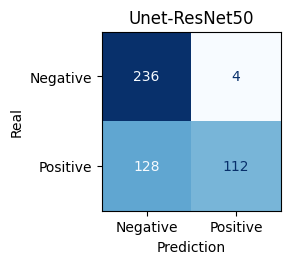

In [14]:
disp = plot_confusion_matrix(test_data.labels, y_pred, title='Unet-ResNet50')

plt.show()